In [1]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")
from src import utils
from src.dataset2D import MRIDataset2D
import albumentations as A
from albumentations.pytorch import ToTensorV2
from codes.new import new_augmentations
utils.set_seed(42)

results_dir = '../../results/preprocessed_data/'
labels=["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]


df_train = pd.read_csv(os.path.join(results_dir, 'df_train_imgs.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test_imgs.csv'))
df_train.head(2)


,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view,img_path,npy_path,ratio
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792
1,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792


  2%|▏         | 396/21160 [00:00<00:05, 3958.39it/s]

100%|██████████| 21160/21160 [00:05<00:00, 4066.61it/s]


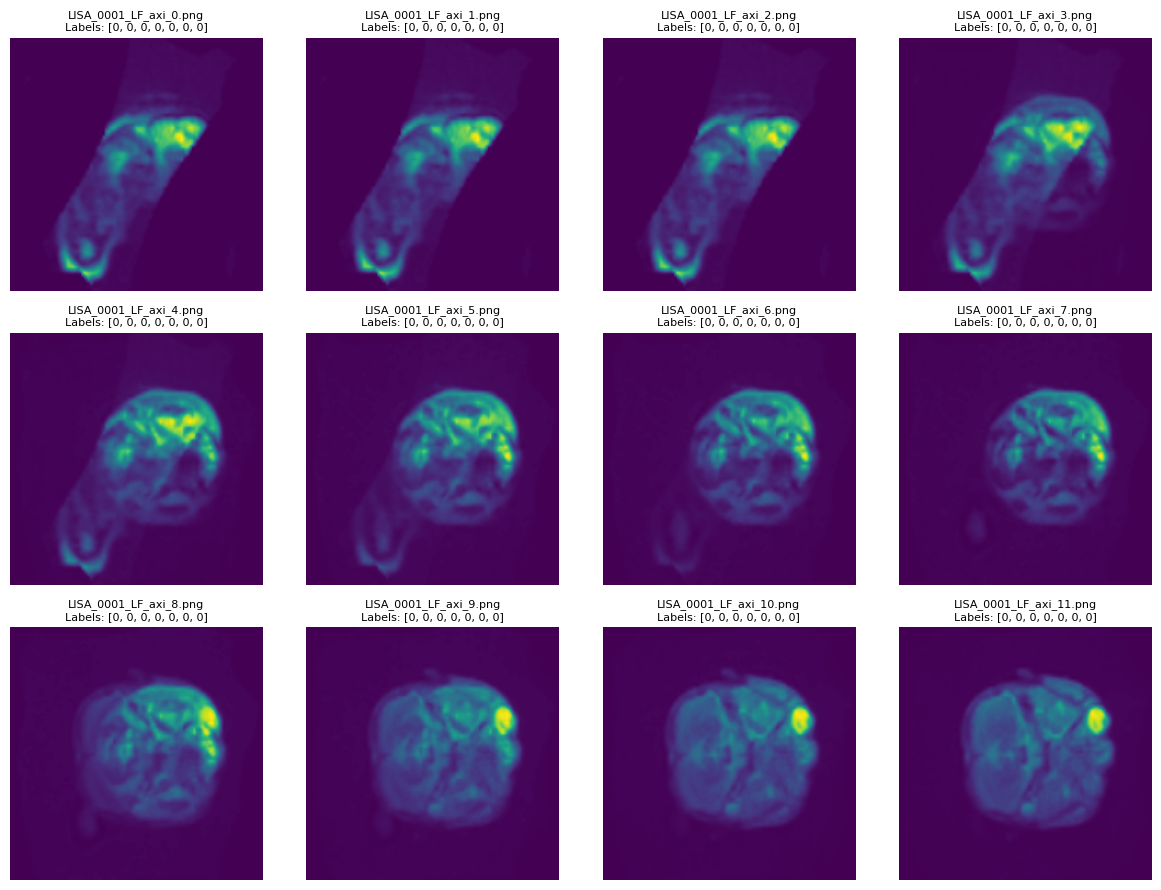

In [2]:
import matplotlib.pyplot as plt

def plot_image_grid(dataset, rows=3, cols=4,cmap="gray"):
    """
    Plotea una matriz (grid) de imágenes transformadas desde un dataset.
    
    Args:
        dataset (Dataset): instancia de MRI2DOrdinalDataset
        rows (int): número de filas
        cols (int): número de columnas
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for i in range(rows * cols):
        img, label, path, view = dataset[i]
        img_np = img.permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
        #print("img mean:",img.mean(),"img max:",img.max(),"img min:",img.min(),"img std:",img.std())        
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        ax.imshow(img_np, cmap=cmap if img_np.shape[2] == 1 else None)
        ax.set_title(f"{os.path.basename(path)}\nLabels: {label.tolist()}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=False,is_numpy=False,labels=labels)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

100%|██████████| 21160/21160 [00:05<00:00, 4029.43it/s]


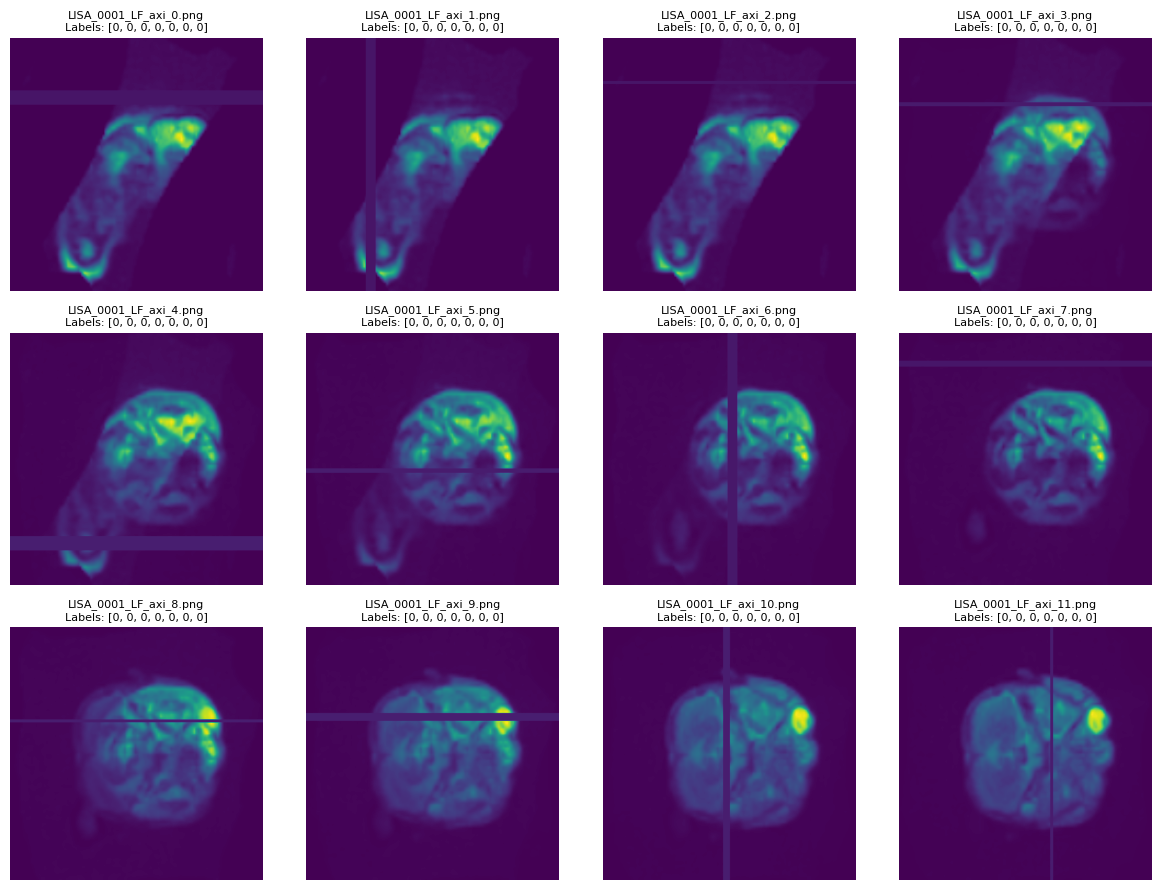

In [3]:
transform = [
            A.Resize(512, 512),
            # 🔁 Flip + rotación leve
            #new_augmentations.CenterDeBorder(max_crop=0.1, p=1.0), #, min_keep=8
            #new_augmentations.RandomZipperStripe(p=1.0, max_amp=0.18, min_period=6, max_period=22, axis="rand"),
            new_augmentations.RandomBandCut(p=1.0),
            ToTensorV2()]
# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=True,is_numpy=True,labels=labels,transform=transform)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

100%|██████████| 21160/21160 [00:04<00:00, 4268.76it/s]


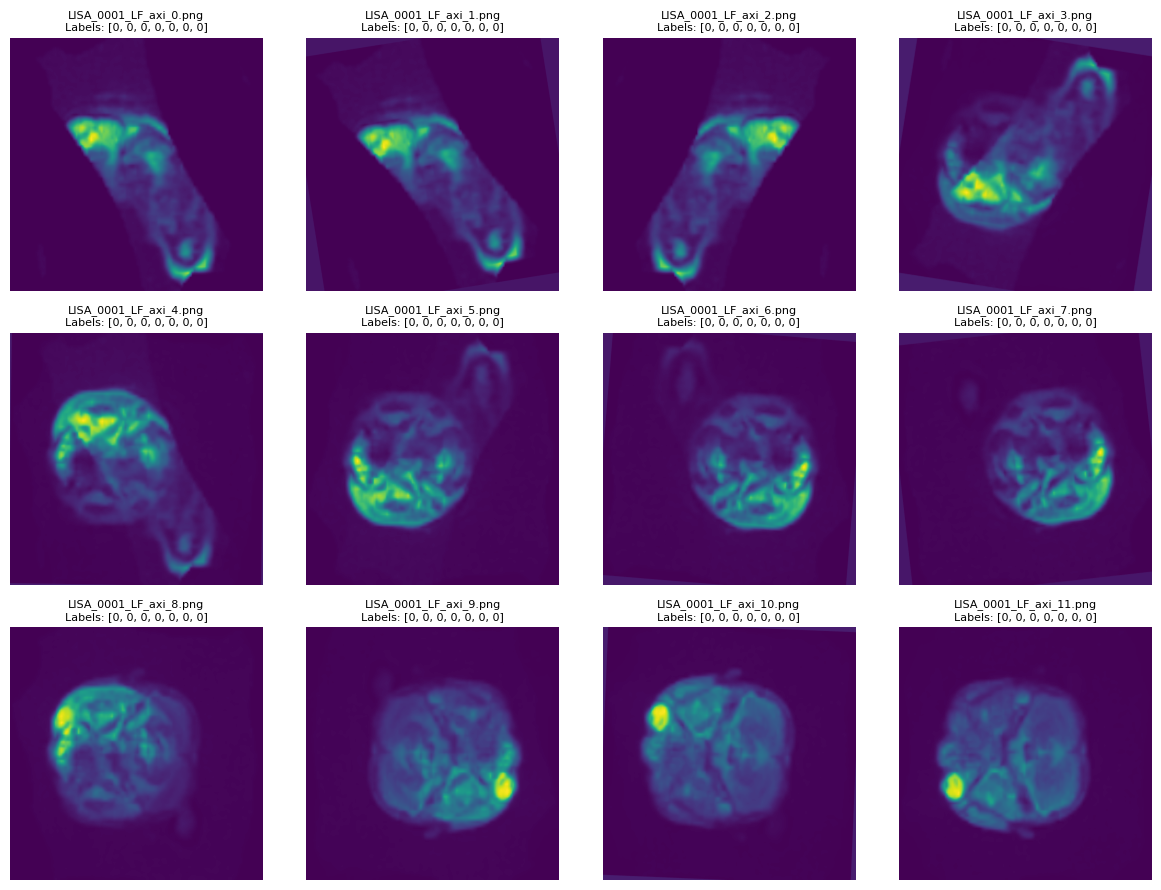

In [4]:
transform = [
            A.Resize(512, 512),
            # 🔁 Flip + rotación leve
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            ToTensorV2()]
# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=True,is_numpy=True,labels=labels,transform=transform)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

100%|██████████| 21160/21160 [00:04<00:00, 4739.81it/s]


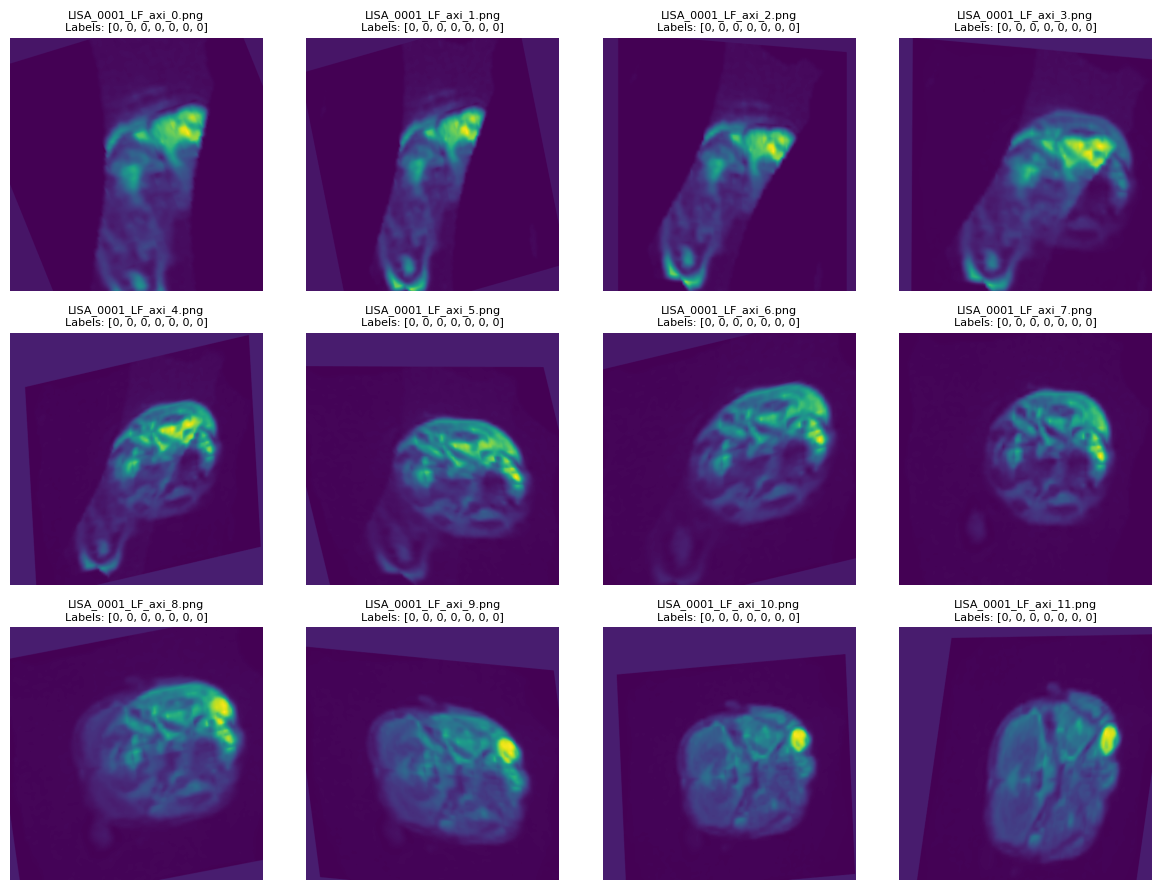

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = [
            A.Resize(512, 512),
            A.OneOf([
                # 🔎 Zoom + desplazamiento leve
                #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                #A.Affine(scale=(0.9, 1.1), translate_percent=(0.0, 0.1), rotate=(-15, 15), p=1.0),
                A.Affine(scale=(0.85, 1.15), translate_percent=(0.0, 0.1), rotate=(-15, 15),
                         shear={'x': (-12, 12), 'y': (-6, 6)},
                           p=1.0),

                # 🔳 Apagar zonas aleatorias (simula distorsión visual o falta de señal)
                #A.CoarseDropout(num_holes_range=(1,2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, p=1.0),
                # 🖼️ Zoom tipo crop + resize (cambia FOV)
                #A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.8, 1.2), p=1),
            ], p=0.99),
            ToTensorV2()]

# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=True,is_numpy=True,labels=labels,transform=transform)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

/home/va0831/env_cris/lib64/python3.9/site-packages/albumentations/augmentations/blur/functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 20) automatically adjusted to (3, 21).
  result = _ensure_odd_values(result, info.field_name)
100%|██████████| 21160/21160 [00:05<00:00, 3957.05it/s]


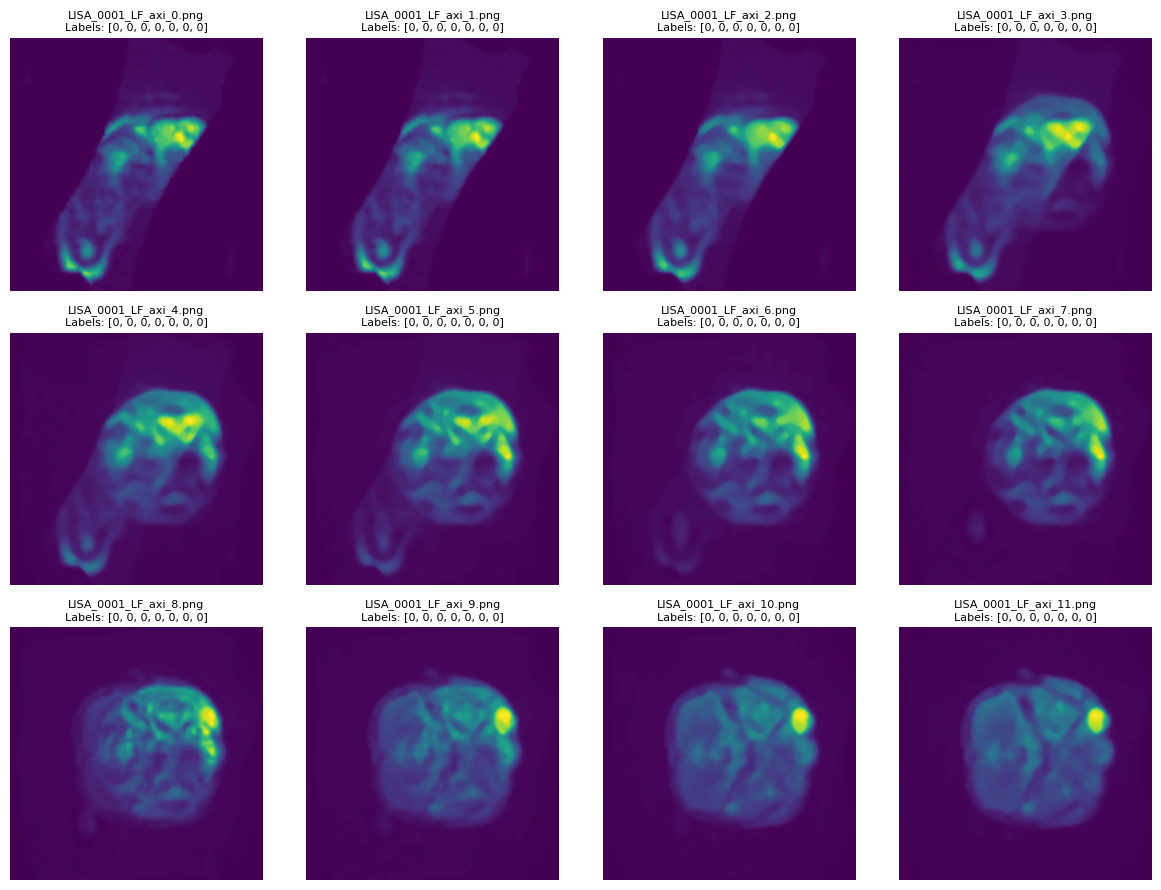

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = [
            A.Resize(512, 512),
            A.OneOf([
                A.GaussNoise(std_range=(1e-5, 2e-1), mean_range=(0,1e-4), p=1.0),   # ruido muy leve
                A.GaussianBlur(sigma_limit= (0.5,5), blur_limit=(3,20), p=1.0),                # desenfoque apenas perceptible
                A.MedianBlur(blur_limit=(3,20), p=1.0),
            ], p=0.99),
            ToTensorV2()]

# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=True,is_numpy=True,labels=labels,transform=transform)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

100%|██████████| 21160/21160 [00:05<00:00, 4138.65it/s]


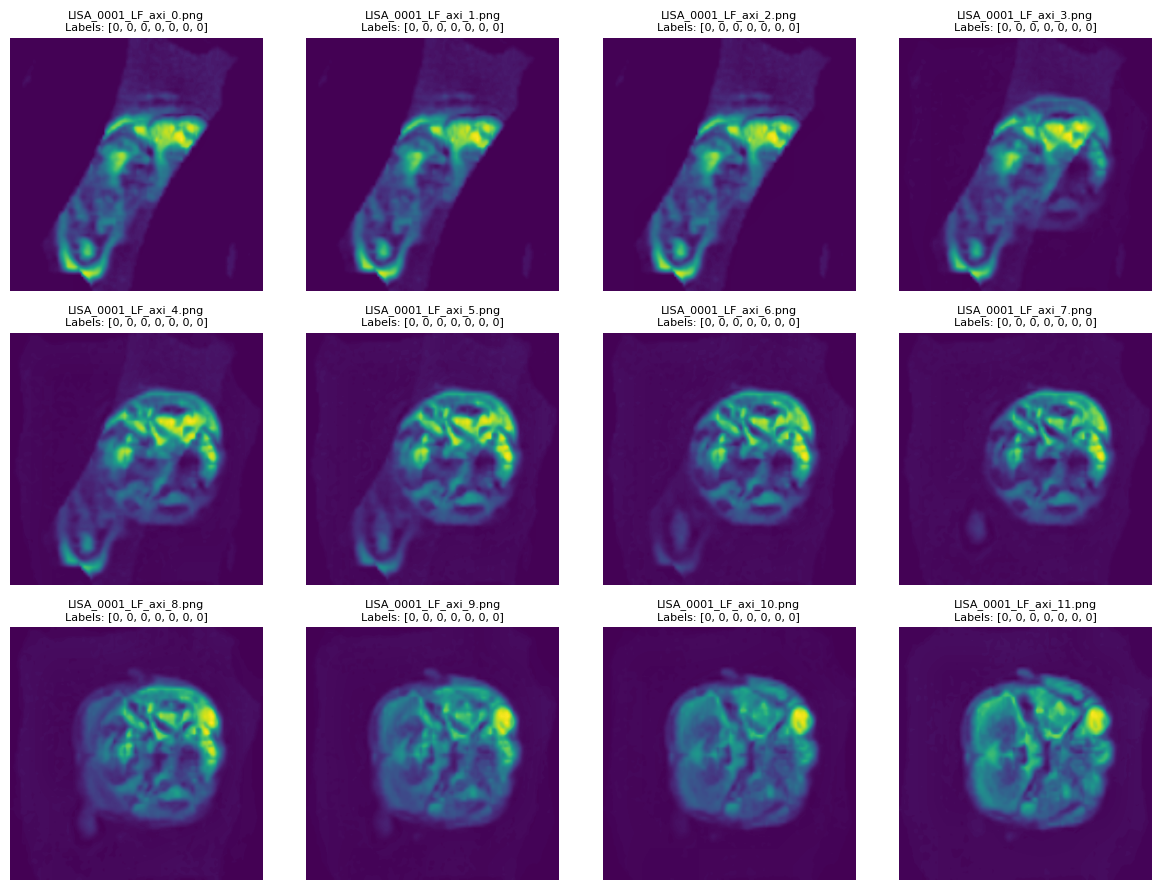

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = [
            A.Resize(512, 512),
            A.OneOf([
                A.MultiplicativeNoise(multiplier=(0.95, 1.2), p=1.0),   # cambia el contraste levemente
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1,p=1.0),
                A.CLAHE(clip_limit=2,p=1.0),
            ], p=0.99),
            ToTensorV2()]

# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_train,is_train=True,use_augmentation=True,is_numpy=True,labels=labels,transform=transform)
# ✅ Visualiza
plot_image_grid(dataset_vis, rows=3, cols=4,cmap=None)

In [7]:
from joblib import dump
import numpy as np
import os
import tqdm 

input_dir = "/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/train/"
output_dir = "/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/train/"

os.makedirs(output_dir, exist_ok=True)

for npy_file in tqdm.tqdm(os.listdir(input_dir)):
    if npy_file.endswith(".npy"):
        arr = np.load(os.path.join(input_dir, npy_file))
        base_name = npy_file.replace(".npy", ".pkl")
        dump(arr, os.path.join(output_dir, base_name))


  1%|▏         | 855/63480 [00:00<00:14, 4270.56it/s]

100%|██████████| 63480/63480 [00:10<00:00, 5977.83it/s] 


In [8]:
from joblib import dump
import numpy as np
import os
import tqdm 

input_dir = "/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/test/"
output_dir = "/data/cristian/projects/med_data/rise-miccai/task-1-val/2d_images_all/test/"

os.makedirs(output_dir, exist_ok=True)

for npy_file in tqdm.tqdm(os.listdir(input_dir)):
    if npy_file.endswith(".npy"):
        arr = np.load(os.path.join(input_dir, npy_file))
        base_name = npy_file.replace(".npy", ".pkl")
        dump(arr, os.path.join(output_dir, base_name))


100%|██████████| 5040/5040 [00:00<00:00, 6525.85it/s]
